In [2]:
import importlib
import warnings
import rich
import asyncio
import nest_asyncio

import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
import anndata as ad

import matplotlib.pyplot as plt

from statannotations.Annotator import Annotator

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat

warnings.filterwarnings("ignore")
sns.set_context("notebook")
nest_asyncio.apply()

sns.set_context("notebook")
sns.set_theme(style='ticks', rc = {'axes.linewidth': 1})
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

In [3]:
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped


@background
def run_sccoda(
        adata: ad.AnnData, 
        sample_identifier: str, 
        cell_type_identifier: str, 
        covariate: str, 
        formula: str, 
        fdr: float, 
        save_path: str, 
        save_prefix: str
):
    """
    Run sccoda on a single cell anndata object
    
    """
    
    idx = [np.where(adata.obs[sample_identifier] == sample)[0][0] for sample in adata.obs[sample_identifier].unique()]
    summary_df = adata.obs.iloc[idx, :].sort_values(by=sample_identifier)
    summary_df.index = summary_df[sample_identifier]
    
    freq = dat.from_scanpy(
        adata,
        cell_type_identifier=cell_type_identifier,
        sample_identifier=sample_identifier,
        covariate_df=summary_df[[covariate]]
    )
    
    model = mod.CompositionalAnalysis(freq, formula=formula, reference_cell_type="automatic")
    sim_results = model.sample_hmc(verbose=False)
    
    sim_results.set_fdr(est_fdr=fdr)

    pkl.dump(sim_results, open(f'{save_path}/{save_prefix}_sccoda_{cell_type_identifier}_{covariate}.pkl', 'wb'))
    sim_results.effect_df.to_csv(f'{save_path}/{save_prefix}_scCODA_{cell_type_identifier}_{covariate}.csv')
    rich.print(f"Ran scCODA for {save_prefix}_{cell_type_identifier}_{covariate}")

    return sim_results


def effect_size_plot(
        ctype: str, 
        cell_type_identifier: str,
        covariate: str,
        fdr: float,
        save_path: str,
        save_prefix: str,
        palettes,
        ax
):
    """
    
    """
    sim_results = pkl.load(open(f'{save_path}/{save_prefix}_sccoda_{cell_type_identifier}_{covariate}.pkl', 'rb'))
    sim_results.set_fdr(est_fdr=fdr)
    # return sim_results
    credible = sim_results.effect_df[sim_results.credible_effects()].reset_index()['Cell Type'].values
    df = sim_results.summary_prepare(hdi_prob=0.9, est_fdr=0.2)[1].reset_index()
    df['estimate'] = (df['HDI 5%']+df['HDI 95%'])/2.0
    df = df.sort_values('estimate')
    df['credible'] = df['Cell Type'].map(lambda c: 'Credible Effect' if c in credible else 'No Credible Effect')
    
    ax = sns.pointplot('estimate','Cell Type', #hue='credible',
        data=df, dodge=False, join=False, ci=None, orient='h', markers='.', color='1', ax=ax) 

    x_coords = []
    y_coords = []
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            if not np.ma.is_masked(x):
                x_coords.append(x)
                y_coords.append(y)
                                
    sns.pointplot('estimate','Cell Type', hue='credible',
        data=df, dodge=False, join=False, ci=None, orient='h', markers='.',palette=palettes, ax=ax)

    colors = [palettes[0] if c in credible else palettes[1] for c in df['Cell Type']]
    ax.errorbar(x_coords, y_coords, xerr=np.abs(df[['HDI 5%','HDI 95%']].T-df['estimate'].T),
        ecolor=colors, fmt=' ', zorder=-1)
    ax.axvline(x = 0, color = 'r', ls='--', lw='1')
    ax.set_xlabel('Effect size (90% HDI)')
    ax.set_ylabel('')
    ax.legend().set_title('')
    ax.legend(frameon=False)
    # plt.xlim(-2.5,2.5)
    # plt.show()
    
    
def proportion_plot(
    adata: ad.AnnData, 
    sample_identifier: str,
    feature_name: str,
    level: str,
    ctype: str,
    ax,
    sig: bool,
    order: list = None,
    ylab: str = '',
    title: str = None
):
    """
    
    """
    
    idx = [np.where(adata.obs[sample_identifier] == sample)[0][0] for sample in adata.obs[sample_identifier].unique()]
    summary_df = adata.obs.iloc[idx, :].sort_values(by=sample_identifier)
    summary_df.index = summary_df[sample_identifier]

    data = dat.from_scanpy(adata, cell_type_identifier=level, sample_identifier=sample_identifier, covariate_df=summary_df[[feature_name]])
    sample_sums = np.sum(data.X, axis=1, keepdims=True)
    X = data.X/sample_sums
    value_name = "Proportion"
    count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
        merge(data.obs[feature_name], left_index=True, right_index=True)
    plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)
    
    ctype_df = plot_df[plot_df['Cell type'] == ctype]
    
    # ax = sns.swarmplot(data=ctype_df, x=feature_name, y='Proportion', hue=feature_name, palette='Accent', size=3, color="1", edgecolor='black',linewidth=0.5, order = order)

    ax = sns.boxplot(
        data=ctype_df, x=feature_name, y='Proportion', width=0.4, hue=feature_name, 
        showcaps=False, saturation=1, whis=2, order = order, 
        flierprops={"marker": ".", 'color':'black'}, boxprops={"edgecolor": 'black', "linewidth":0.9},
        whiskerprops={'color':'black', "linewidth":0.9}, medianprops={"color": "black","linewidth":1},
        palette='Accent', dodge=False, ax=ax
    )
    annotator = Annotator(ax, data=ctype_df, pairs = [order], x=feature_name, y='Proportion')
    annotator.configure(verbose=False)
    annotator.set_custom_annotations(["*" if sig else "ns"])
    annotator.annotate()

    ax.set_title(f'{ctype}' if title is None else title)
    ax.set_xlabel('')
    ax.set_ylabel(ylab)
    ax.get_legend().remove()
    ax.locator_params(axis='y', nbins=5)
    

def proportion_plot_group(
    adata: ad.AnnData, 
    sample_identifier: str,
    feature_name: str,
    level: str,
    ctypes: str,
    ax,
    credible: list,
    order: list = None,
    bta: int = 1.15
):
    idx = [np.where(adata.obs[sample_identifier] == sample)[0][0] for sample in adata.obs[sample_identifier].unique()]
    summary_df = adata.obs.iloc[idx, :].sort_values(by=sample_identifier)
    summary_df.index = summary_df[sample_identifier]

    data = dat.from_scanpy(adata, cell_type_identifier=level, sample_identifier=sample_identifier, covariate_df=summary_df[[feature_name]])
    sample_sums = np.sum(data.X, axis=1, keepdims=True)
    X = data.X/sample_sums
    value_name = "Proportion"
    count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
        merge(data.obs[feature_name], left_index=True, right_index=True)
    plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)

    ctype_df = plot_df[plot_df['Cell type'].isin(ctypes)]

    sig_y = 1.1*ctype_df['Proportion'].max() 

    ax = sns.boxplot(
        data=ctype_df, x='Cell type', y='Proportion', width=0.6, hue=feature_name, 
        showcaps=False, saturation=1, whis=2, hue_order=order, order=ctypes,
        flierprops={"marker": ".", 'color':'black'}, boxprops={"edgecolor": 'black', "linewidth":0.9},
        whiskerprops={'color':'black', "linewidth":0.9}, medianprops={"color": "black","linewidth":1},
        palette='Accent', ax=ax
    )
    [ax.axvline(x+.5,color='grey', lw=0.05, ls=':') for x in ax.get_xticks()[:-1]]

    for i in range(len(ctypes)):
        kwargs=dict(ha="center", va="bottom", size=14)
        if ctypes[i] in credible:
            plt.text(y=sig_y, x=i, s="*", color=sns.color_palette('Set1')[0], **kwargs)
            plt.text(y=sig_y, x=i, s="__", color=sns.color_palette('Set1')[0], **kwargs)


    ax.set_ylim(ax.get_ylim()[0],1.15*sig_y)
    ax.set_xlabel('')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='y', colors='black')
    ax.tick_params(axis='x', colors='black')
    plt.legend(frameon=False, bbox_to_anchor=(bta, 1))
    plt.xticks(rotation=90)
    adjust_box_widths(fig, 0.8)

from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [109]:
adatas = {}
for ctype in ['B_cells', 'T_cells', 'myeloid_cells', 'stromal', 'all']:
    
    path = "/home/dchafamo/final/data/" + ("combined_dataset_final_v2.h5ad" if ctype == 'all' else f"combined_{ctype}_fine.h5ad")
    adatas[ctype] = sc.read(path)

In [ ]:
for ctype in ['B_cells', 'T_cells', 'myeloid_cells', 'stromal', 'all']:
    adata = adatas[ctype]
    for level in ['cell_types_level_4', 'cell_types_level_5']:
        covariate  = 'condition'
        run_sccoda(adata, 'donor', level, covariate, f"C({covariate}, Treatment('RLN'))", 0.1, 'results/sccoda', ctype)         


In [ ]:
for ctype in ['B_cells', 'T_cells', 'myeloid_cells', 'stromal', 'all']:
    adata = adatas[ctype]                                   
    adata.obs['sample_type'] = adata.obs['condition'].astype(str) + adata.obs['ebv_status'].astype(str).apply(lambda x:''if x=='na' else '_'+x)
    adata.obs['sample_type'] = adata.obs['sample_type'].map({'HL_negative': 'HL EBV-', 'HL_positive': 'HL EBV+', 'RLN': 'RLN'})
    adata = adata[adata.obs.sample_type.isin(['HL EBV-', 'HL EBV+'])].copy()
    
    for level in ['cell_types_level_4', 'cell_types_level_5']:
        covariate = 'sample_type'
        rich.print(f"\n\nRunning scCODA for:\n\tCelltype: {ctype}\n\tLevel: {level}\n\tCovariate: {covariate}")
        run_sccoda(adata, 'donor', level, covariate, f"C({covariate}, Treatment('HL EBV-'))", 0.1, 'results/sccoda', ctype)
    

In [4]:
adata = sc.read("/home/dchafamo/final/data/combined_dataset_final_v2.h5ad")
adata.obs['sample_type'] = adata.obs['condition'].astype(str) + adata.obs['ebv_status'].astype(str).apply(lambda x:''if x=='na' else '_'+x)
adata.obs['sample_type'] = adata.obs['sample_type'].map({'HL_negative': 'HL EBV-', 'HL_positive': 'HL EBV+', 'RLN': 'RLN'})
adata = adata[adata.obs.sample_type.isin(['HL EBV-', 'HL EBV+'])].copy()

In [5]:
mapping = {
    'B_GC':'GC B cells',
    'B_GC_cycling':'Cycling GC B cells',
    'B_memory':'Memory B cells',
    'B_naive':'Naive B cells',
    'BEC_arterial':'Blood endothelial cells - arterial',
    'BEC_venous':'Blood endothelial cells - venous',
    'CD4_T_naive':'Naive CD4+ T cells',
    'CD8_T_effector':'Effector CD8+ T cells',
    'CD8_T_naive':'Naive CD8+ T cells',
    'DC_cycling':'Cycling DCs',
    'DC1':'DC1',
    'DC2':'DC2',
    'DN_cytotoxic_T_cells':'CD4-/CD8- cytotoxic T cells',
    'FDC':'Follicular dendritic cells',
    'Follicular_helper_T_cells':'Follicular helper T cells',
    'FRC':'Fibroblastic reticular cells (FRC)',
    'FRC_cycling':'Cycling FRCs',
    'ILC3':'ILC3',
    'LEC':'Lymphatic endothelial cells (LEC)',
    'LEC_cycling':'Cycling LECs',
    'Macrophages':'Macrophages',
    'MAIT_cells':'MAIT cells',
    'migratory_DC':'Migratory DCs',
    'Monocytes':'Monocytes',
    'NK_cells':'NK cells',
    'pDC':'Plasmacytoid dendritic cells',
    'Pericyte':'Pericytes',
    'Plasma_cells':'Plasma cells',
    'Plasmablasts':'Plasmablasts',
    'Regulatory_T_cells':'Regulatory T cells',
    'T_cycling':'Cycling T cells',
    'Tumor':'Tumor cells'
}

In [6]:
adata.obs.cell_types_level_4 = adata.obs.cell_types_level_4.map(mapping) 

In [7]:
sim_results = pkl.load(open(f'results/sccoda/all_sccoda_cell_types_level_4_sample_type.pkl', 'rb'))
sim_results.set_fdr(est_fdr=0.4)
credible = [mapping[c] for c in sim_results.effect_df[sim_results.credible_effects()].reset_index()['Cell Type'].values]
credible

['Memory B cells', 'Naive CD4+ T cells', 'Macrophages', 'Tumor cells']

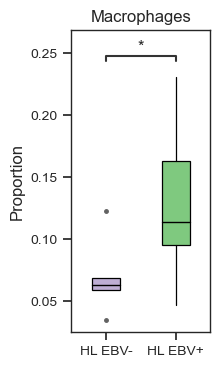

In [9]:
ctype = 'Macrophages'
fig, ax = plt.subplots(figsize=(1.8, 4), dpi=100)
proportion_plot(
    adata, 'donor', 'sample_type', 'cell_types_level_4', ctype, ax=ax, ylab='Proportion', order=['HL EBV-', 'HL EBV+'], sig=(ctype in credible)
)

In [ ]:
for ctype in adata.obs.cell_types_level_4.unique():
    fig, ax = plt.subplots(figsize=(1.8, 4), dpi=100)
    proportion_plot(
        adata, 'donor', 'sample_type', 'cell_types_level_4', ctype, ax=ax, ylab='Proportion', order=['HL EBV-', 'HL EBV+'], sig=(ctype in credible)
    )
    fig.savefig(f'figures/sccoda/all_EBV_level4_{ctype.replace(r"/","")}.png', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
    fig.savefig(f'figures/sccoda/all_EBV_level4_{ctype.replace(r"/","")}.pdf', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)

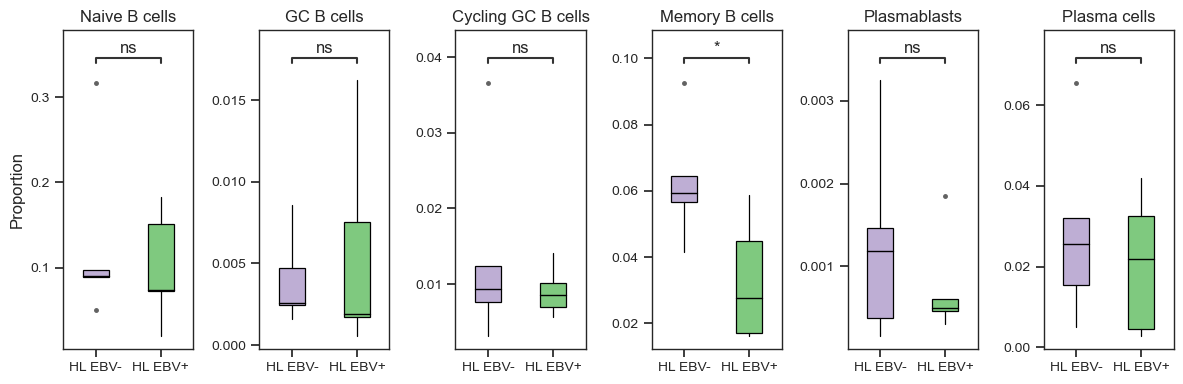

In [11]:
ctypes = ['Naive B cells','GC B cells','Cycling GC B cells','Memory B cells','Plasmablasts','Plasma cells']
fig, axs = plt.subplots(1,len(ctypes), figsize=(2*len(ctypes), 4), dpi=100)
for i, ctype in enumerate(ctypes):
    ylab = 'Proportion' if i == 0 else ''
    proportion_plot(
        adata, 'donor', 'sample_type', 'cell_types_level_4', ctype, ax=axs[i], ylab=ylab, order=['HL EBV-', 'HL EBV+'], sig=(ctype in credible)
    )
fig.tight_layout()
fig.savefig(f'figures/sccoda/all_EBV_level4_B_cells_individual_scale.png', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
fig.savefig(f'figures/sccoda/all_EBV_level4_B_cells_individual_scale.pdf', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)

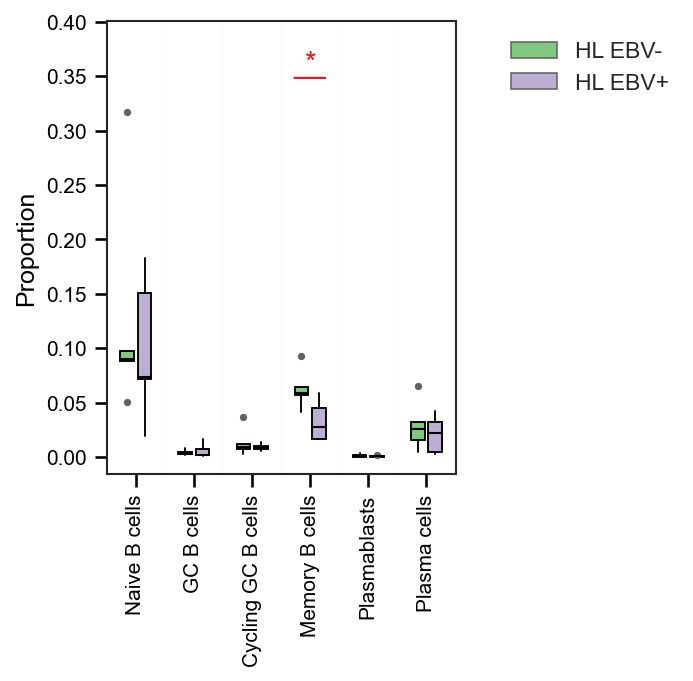

In [12]:
fig, ax = plt.subplots(1,1, figsize=(0.5*len(ctypes), 4), dpi=150)
proportion_plot_group(adata, 'donor', 'sample_type', 'cell_types_level_4', ctypes, ax=ax, order=['HL EBV-', 'HL EBV+'], credible=credible, bta=1.1)
fig.savefig(f'figures/sccoda/all_EBV_level4_B_cells.png', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
fig.savefig(f'figures/sccoda/all_EBV_level4_B_cells.pdf', dpi=200, bbox_inches="tight", facecolor='white', transparent=False)

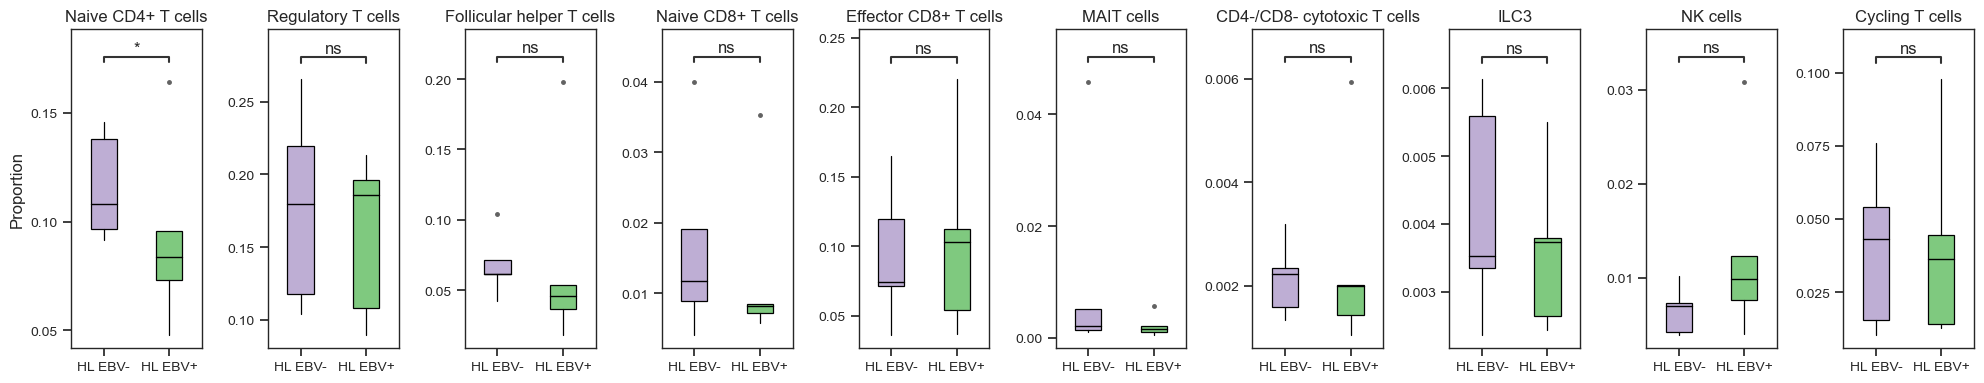

In [13]:
ctypes = [
    'Naive CD4+ T cells','Regulatory T cells','Follicular helper T cells', 'Naive CD8+ T cells',
    'Effector CD8+ T cells','MAIT cells','CD4-/CD8- cytotoxic T cells','ILC3','NK cells','Cycling T cells'
]
fig, axs = plt.subplots(1,len(ctypes), figsize=(2*len(ctypes), 4), dpi=100)
for i, ctype in enumerate(ctypes):
    ylab = 'Proportion' if i == 0 else ''
    proportion_plot(
        adata, 'donor', 'sample_type', 'cell_types_level_4', ctype, ax=axs[i], ylab=ylab, order=['HL EBV-', 'HL EBV+'], sig=(ctype in credible)
    )
fig.tight_layout()
fig.savefig(f'figures/sccoda/all_EBV_level4_T_cells_individual_scale.png', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
fig.savefig(f'figures/sccoda/all_EBV_level4_T_cells_individual_scale.pdf', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)

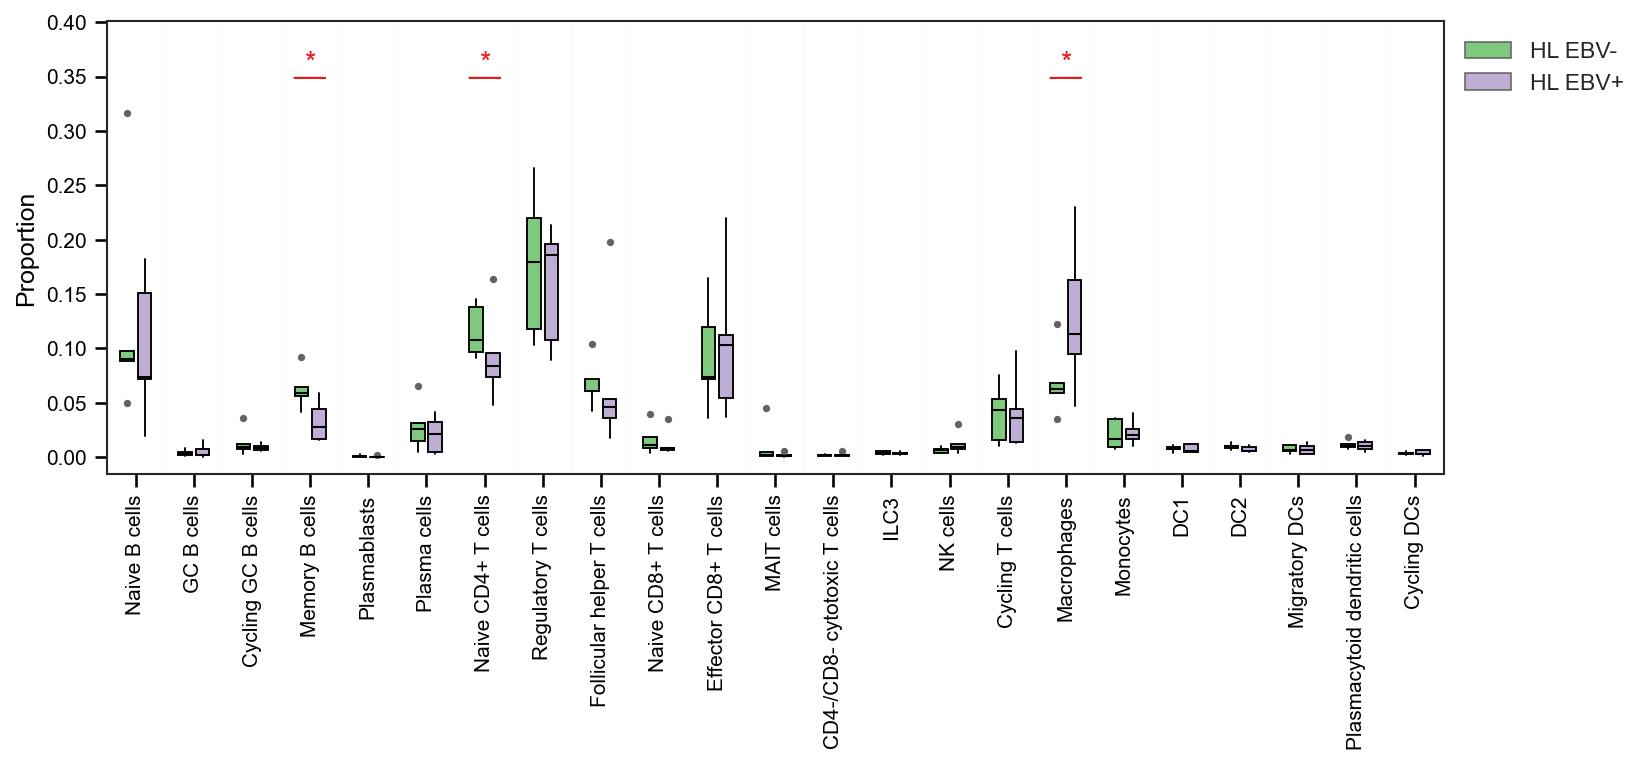

In [26]:
fig, ax = plt.subplots(1,1, figsize=(0.5*len(ctypes), 4), dpi=150)
proportion_plot_group(adata, 'donor', 'sample_type', 'cell_types_level_4', ctypes, ax=ax, order=['HL EBV-', 'HL EBV+'], credible=credible, bta=1.15)
fig.savefig(f'figures/sccoda/all_EBV_level4_T_cells.png', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
fig.savefig(f'figures/sccoda/all_EBV_level4_T_cells.pdf', dpi=200, bbox_inches="tight", facecolor='white', transparent=False)

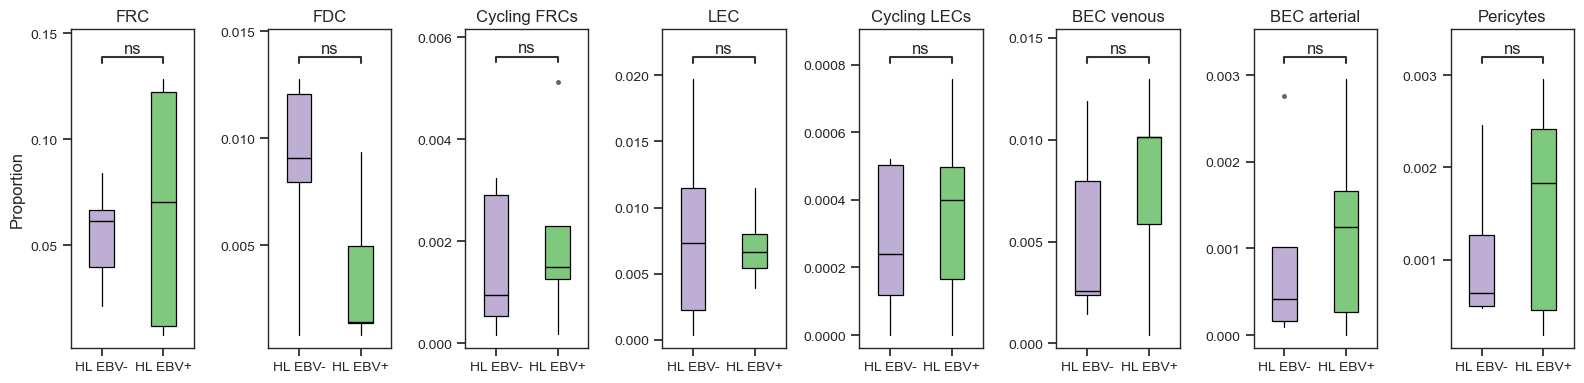

In [15]:
ctypes = [
    'Fibroblastic reticular cells (FRC)', 'Follicular dendritic cells', 'Cycling FRCs', 'Lymphatic endothelial cells (LEC)',
    'Cycling LECs','Blood endothelial cells - venous', 'Blood endothelial cells - arterial', 'Pericytes'
]
shorten = {
    'Fibroblastic reticular cells (FRC)': 'FRC', 'Follicular dendritic cells': 'FDC', 'Lymphatic endothelial cells (LEC)':'LEC',
    'Blood endothelial cells - venous': 'BEC venous', 'Blood endothelial cells - arterial': 'BEC arterial'
}
fig, axs = plt.subplots(1,len(ctypes), figsize=(2*len(ctypes), 4), dpi=100)
for i, ctype in enumerate(ctypes):
    ylab = 'Proportion' if i == 0 else ''
    title = ctype if ctype not in shorten else shorten[ctype]
    proportion_plot(
        adata, 'donor', 'sample_type', 'cell_types_level_4', ctype, ax=axs[i], ylab=ylab, order=['HL EBV-', 'HL EBV+'], sig=(ctype in credible), title=title
    )
fig.tight_layout()
fig.savefig(f'figures/sccoda/all_EBV_level4_stromal_individual_scale.png', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
fig.savefig(f'figures/sccoda/all_EBV_level4_stromal_individual_scale.pdf', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)

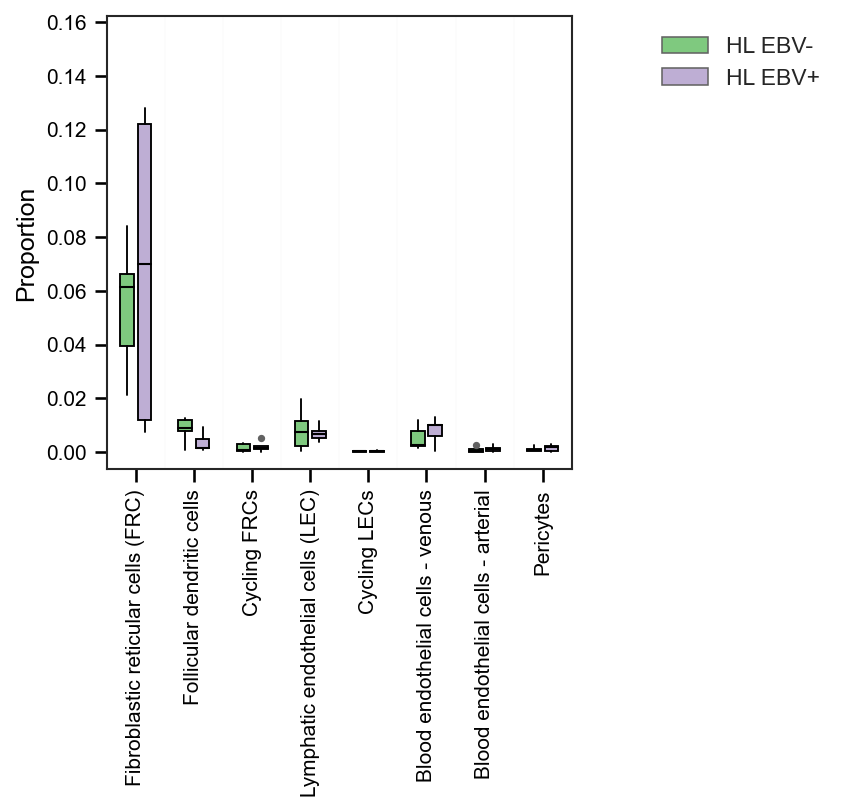

In [16]:
fig, ax = plt.subplots(1,1, figsize=(0.5*len(ctypes), 4), dpi=150)
proportion_plot_group(adata, 'donor', 'sample_type', 'cell_types_level_4', ctypes, ax=ax, order=['HL EBV-', 'HL EBV+'], credible=credible)
fig.savefig(f'figures/sccoda/all_EBV_level4_stromal.png', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
fig.savefig(f'figures/sccoda/all_EBV_level4_stromal.pdf', dpi=200, bbox_inches="tight", facecolor='white', transparent=False)

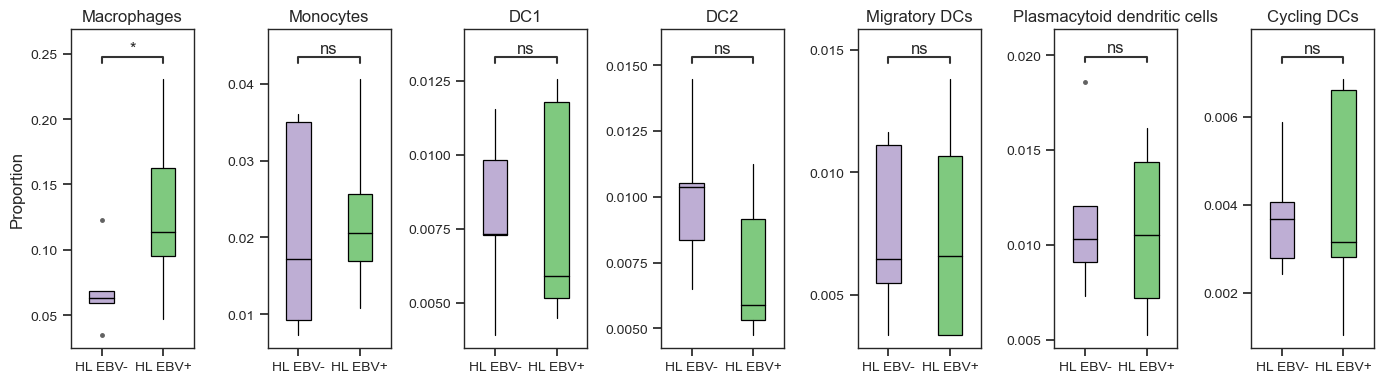

In [17]:
ctypes = [
    'Macrophages','Monocytes','DC1','DC2','Migratory DCs','Plasmacytoid dendritic cells','Cycling DCs'
]
fig, axs = plt.subplots(1,len(ctypes), figsize=(2*len(ctypes), 4), dpi=100)
for i, ctype in enumerate(ctypes):
    ylab = 'Proportion' if i == 0 else ''
    proportion_plot(
        adata, 'donor', 'sample_type', 'cell_types_level_4', ctype, ax=axs[i], ylab=ylab, order=['HL EBV-', 'HL EBV+'], sig=(ctype in credible)
    )
fig.tight_layout()
fig.savefig(f'figures/sccoda/all_EBV_level4_myeloid_cells_individual_scale.png', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
fig.savefig(f'figures/sccoda/all_EBV_level4_myeloid_cells_individual_scale.pdf', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)

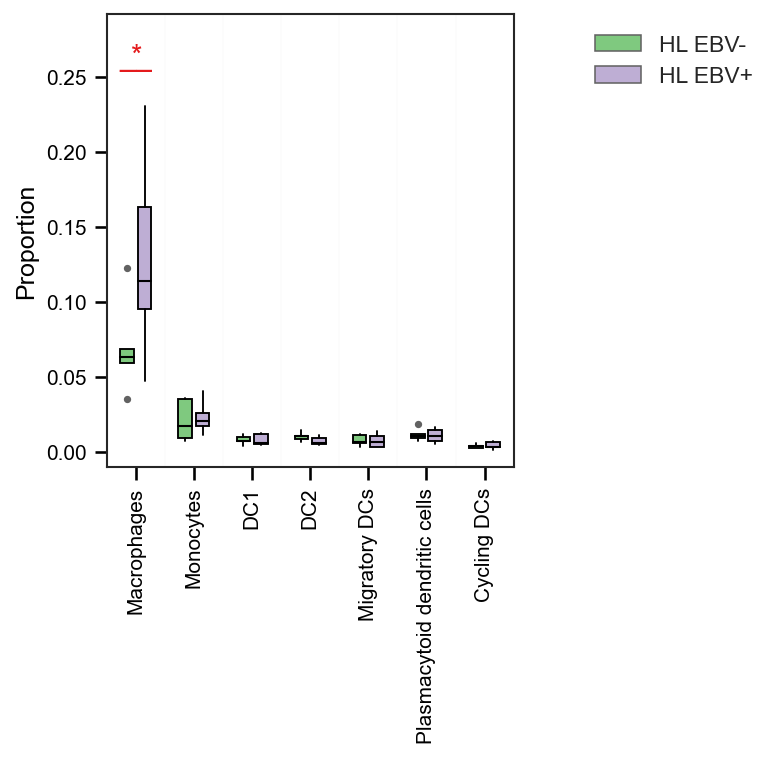

In [18]:
fig, ax = plt.subplots(1,1, figsize=(0.5*len(ctypes), 4), dpi=150)
proportion_plot_group(adata, 'donor', 'sample_type', 'cell_types_level_4', ctypes, ax=ax, order=['HL EBV-', 'HL EBV+'], credible=credible)
fig.savefig(f'figures/sccoda/all_EBV_level4_myeloid_cells.png', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
fig.savefig(f'figures/sccoda/all_EBV_level4_myeloid_cells.pdf', dpi=200, bbox_inches="tight", facecolor='white', transparent=False)

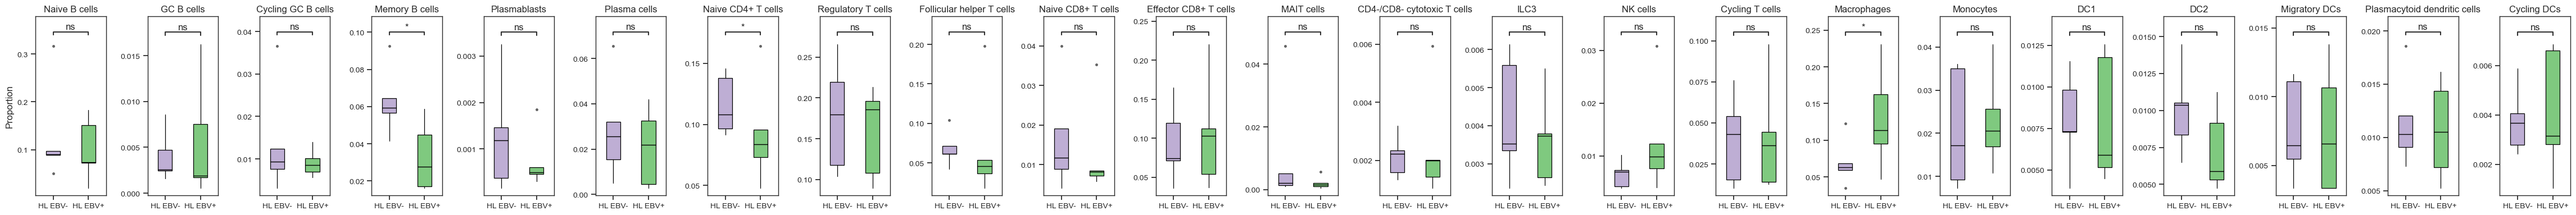

In [19]:
ctypes = [
    'Naive B cells','GC B cells','Cycling GC B cells','Memory B cells','Plasmablasts','Plasma cells',
    'Naive CD4+ T cells','Regulatory T cells','Follicular helper T cells', 'Naive CD8+ T cells',
    'Effector CD8+ T cells','MAIT cells','CD4-/CD8- cytotoxic T cells','ILC3','NK cells','Cycling T cells',
    'Macrophages','Monocytes','DC1','DC2','Migratory DCs','Plasmacytoid dendritic cells','Cycling DCs'
]
fig, axs = plt.subplots(1,len(ctypes), figsize=(2*len(ctypes), 4), dpi=100)
for i, ctype in enumerate(ctypes):
    ylab = 'Proportion' if i == 0 else ''
    proportion_plot(
        adata, 'donor', 'sample_type', 'cell_types_level_4', ctype, ax=axs[i], ylab=ylab, order=['HL EBV-', 'HL EBV+'], sig=(ctype in credible)
    )
fig.tight_layout()
fig.savefig(f'figures/sccoda/all_EBV_level4_immune_individual_scale.png', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
fig.savefig(f'figures/sccoda/all_EBV_level4_immune_individual_scale.pdf', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)

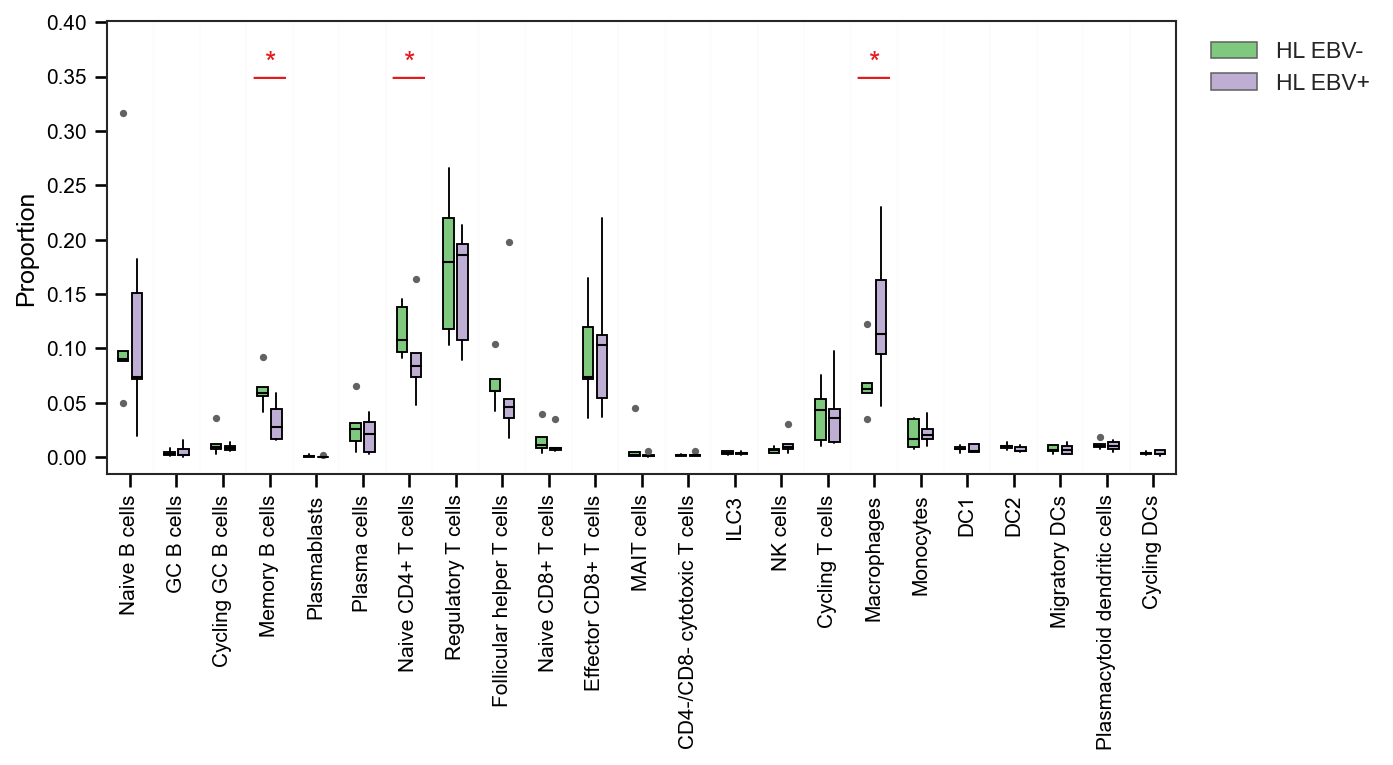

In [28]:
fig, ax = plt.subplots(1,1, figsize=(0.4*len(ctypes), 4), dpi=150)
proportion_plot_group(adata, 'donor', 'sample_type', 'cell_types_level_4', ctypes, ax=ax, order=['HL EBV-', 'HL EBV+'], credible=credible, bta=1.2)
fig.savefig(f'figures/sccoda/all_EBV_level4_immune_cells.png', dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
fig.savefig(f'figures/sccoda/all_EBV_level4_immune_cells.pdf', dpi=200, bbox_inches="tight", facecolor='white', transparent=False)